In [2]:
# Environment
!nvidia-smi

Thu Apr 20 03:57:19 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090         On | 00000000:65:00.0 Off |                  N/A |
|  0%   48C    P8               38W / 390W|    228MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [490]:
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 459.0/459.0 kB 5.1 MB/s eta 0:00:00a 0:00:01


# Download the datasets

    The TMDB 5000 Movie Dataset is a popular dataset used in the field of data science and machine learning for analyzing and predicting movie-related information. It contains information about over 5000 movies, including details such as movie titles, release dates, budgets, revenues, genres, ratings, and more. This dataset is widely used for various tasks, such as movie recommendation systems, sentiment analysis, and box office revenue prediction.

To access the TMDB 5000 Movie Dataset, you can download it from Kaggle, a popular online platform for data science and machine learning competitions. The dataset can be found at the following link: https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata?resource=download. 

In [10]:
!ls tmdb-5000

tmdb_5000_credits.csv  tmdb_5000_movies.csv


# Import the necessary libraries

In [491]:
import pandas as pd
import numpy as np 
import re
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import json
import matplotlib.pyplot as plt
import re
from wordcloud import WordCloud

# Load the datasets

In [6]:
credits = pd.read_csv("tmdb-5000/tmdb_5000_credits.csv")
movies = pd.read_csv("tmdb-5000/tmdb_5000_movies.csv")

In [16]:
credits.head(2)

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


In [15]:
movies.head(2)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


# Remove all the missing values in the dataset.





In [9]:
movies = movies.dropna()
credits = credits.dropna()

# Prepare the datasets to be used

In [195]:
datasets = movies[["id", "original_title", "overview", "genres", "keywords", "tagline", "vote_average", "vote_count"]]

In [711]:
datasets.head(3)

,id,original_title,overview,genres,keywords,tagline,vote_average,vote_count
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",Enter the World of Pandora.,7.2,11800
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","At the end of the world, the adventure begins.",6.9,4500
2,206647,Spectre,A cryptic message from Bond’s past sends him o...,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",A Plan No One Escapes,6.3,4466


# I will implement a hybrid approach combining collaborative-based filtering and content-based filtering to recommend similar movies to users based on their recently watched movies. My methodology is as follows:

    1. First, I will filter the top 100 similar movies using "keywords," "tagline," and "genres".
    2. Next, I will filter the top 50 movies based on their "vote_count."
    3. Finally, I will apply a final filter based on the top 15 similar "overview" of the movies.

# 1. We will start by filtering the top 100 similar movies based on their "keywords," "tagline," and "genres". 

### To do this, I'll extract the genres and keywords information from the dataset, which are stored in json format. 

    I'll create a new dataframe for this.

In [295]:
datasets.genres[0]

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

In [296]:
datasets.keywords[0]

'[{"id": 1463, "name": "culture clash"}, {"id": 2964, "name": "future"}, {"id": 3386, "name": "space war"}, {"id": 3388, "name": "space colony"}, {"id": 3679, "name": "society"}, {"id": 3801, "name": "space travel"}, {"id": 9685, "name": "futuristic"}, {"id": 9840, "name": "romance"}, {"id": 9882, "name": "space"}, {"id": 9951, "name": "alien"}, {"id": 10148, "name": "tribe"}, {"id": 10158, "name": "alien planet"}, {"id": 10987, "name": "cgi"}, {"id": 11399, "name": "marine"}, {"id": 13065, "name": "soldier"}, {"id": 14643, "name": "battle"}, {"id": 14720, "name": "love affair"}, {"id": 165431, "name": "anti war"}, {"id": 193554, "name": "power relations"}, {"id": 206690, "name": "mind and soul"}, {"id": 209714, "name": "3d"}]'

In [411]:
keywords_taglines_genres = datasets[["id", "original_title"]]

In [412]:
keywords_taglines_genres.head()

,id,original_title
0,19995,Avatar
1,285,Pirates of the Caribbean: At World's End
2,206647,Spectre
3,49026,The Dark Knight Rises
4,49529,John Carter


In [413]:
keywords_taglines_genres["genres_combined"] = datasets.genres.apply(lambda row: ' ' . join([x['name'].lower() for x in json.loads(row)]))
keywords_taglines_genres["keywords_combined"] = datasets.keywords.apply(lambda row: ' ' . join([x['name'].lower() for x in json.loads(row)]))
keywords_taglines_genres["tagline_processed"] = datasets.tagline.apply(lambda row: row.lower())

/tmp/ipykernel_279117/1899000634.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keywords_taglines_genres["genres_combined"] = datasets.genres.apply(lambda row: ' ' . join([x['name'].lower() for x in json.loads(row)]))
/tmp/ipykernel_279117/1899000634.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keywords_taglines_genres["keywords_combined"] = datasets.keywords.apply(lambda row: ' ' . join([x['name'].lower() for x in json.loads(row)]))
/tmp/ipykernel_279117/1899000634.py:3: SettingWithCopyWarning:

In [414]:
keywords_taglines_genres.head(2)

,id,original_title,genres_combined,keywords_combined,tagline_processed
0,19995,Avatar,action adventure fantasy science fiction,culture clash future space war space colony so...,enter the world of pandora.
1,285,Pirates of the Caribbean: At World's End,adventure fantasy action,ocean drug abuse exotic island east india trad...,"at the end of the world, the adventure begins."


### Next, we will merge them to prepare for the encoding process.

In [415]:
keywords_taglines_genres["keywords_taglines_genres"] = keywords_taglines_genres.apply((lambda row: ' ' . join([row.genres_combined, row.keywords_combined, row.tagline_processed])), axis=1)

/tmp/ipykernel_279117/3921606734.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keywords_taglines_genres["keywords_taglines_genres"] = keywords_taglines_genres.apply((lambda row: ' ' . join([row.genres_combined, row.keywords_combined, row.tagline_processed])), axis=1)


In [416]:
keywords_taglines_genres.head(2)

,id,original_title,genres_combined,keywords_combined,tagline_processed,keywords_taglines_genres
0,19995,Avatar,action adventure fantasy science fiction,culture clash future space war space colony so...,enter the world of pandora.,action adventure fantasy science fiction cultu...
1,285,Pirates of the Caribbean: At World's End,adventure fantasy action,ocean drug abuse exotic island east india trad...,"at the end of the world, the adventure begins.",adventure fantasy action ocean drug abuse exot...


### To enable computation, we need to encode the words as we cannot process data in string format. However, simply encoding each word into numbers may not provide enough information. In this case, we can use the CountVectorizer to encode the data, which will not only enable computation but also provide additional insights into the data.

    For this purpose, I will use the stop words provided by scikit-learn as the default, which excludes words like 'the', 'and', 'a', 'an', 'in', 'of', 'to', etc.

In [417]:
keywords_taglines_genres = keywords_taglines_genres.sort_values("id")
keywords_taglines_genres = keywords_taglines_genres.reset_index(drop=True)

In [418]:
keywords_taglines_genres.head()

,id,original_title,genres_combined,keywords_combined,tagline_processed,keywords_taglines_genres
0,11,Star Wars,adventure action science fiction,android galaxy hermit death star lightsaber je...,"a long time ago in a galaxy far, far away...",adventure action science fiction android galax...
1,12,Finding Nemo,animation family,father son relationship harbor underwater fish...,"there are 3.7 trillion fish in the ocean, they...",animation family father son relationship harbo...
2,14,American Beauty,drama,male nudity female nudity adultery midlife cri...,look closer.,drama male nudity female nudity adultery midli...
3,22,Pirates of the Caribbean: The Curse of the Bla...,adventure fantasy action,exotic island blacksmith east india trading co...,prepare to be blown out of the water.,adventure fantasy action exotic island blacksm...
4,24,Kill Bill: Vol. 1,action crime,japan coma martial arts kung fu underworld yak...,go for the kill.,action crime japan coma martial arts kung fu u...


In [419]:
keywords_taglines_genres.keywords_taglines_genres

0       adventure action science fiction android galax...
1       animation family father son relationship harbo...
2       drama male nudity female nudity adultery midli...
3       adventure fantasy action exotic island blacksm...
4       action crime japan coma martial arts kung fu u...
                              ...                        
1488    comedy alcohol bar party divorce family hit an...
1489    action drama new jersey martial arts sister sp...
1490    adventure blow job cigarette smoking illegal d...
1491    drama undercover dog animal welfare animal rig...
1492    comedy family drama  it’s better to stand out ...
Name: keywords_taglines_genres, Length: 1493, dtype: object

In [420]:
vectorizer = CountVectorizer(stop_words='english')
vectorized = vectorizer.fit_transform(keywords_taglines_genres.keywords_taglines_genres)

In [421]:
vectorized.toarray().shape

(1493, 5591)

In [422]:
vectorized.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### We have obtained information about each word, and now we can plot the top 10 most frequent words in the sentences.

In [423]:
words = vectorizer.get_feature_names_out()
words

array(['000', '007', '05', ..., 'zwei', 'γη', '最后的舞者'], dtype=object)

In [424]:
freqs = vectorized.sum(axis=0).A1 # sum matrix into a 1D NumPy array
freqs

array([10,  6,  2, ...,  1,  1,  1])

In [425]:
sorted_indices = freqs.argsort()[::-1] # Sort the words by frequency in descending order
words = [words[idx] for idx in sorted_indices]
freqs = freqs[sorted_indices]

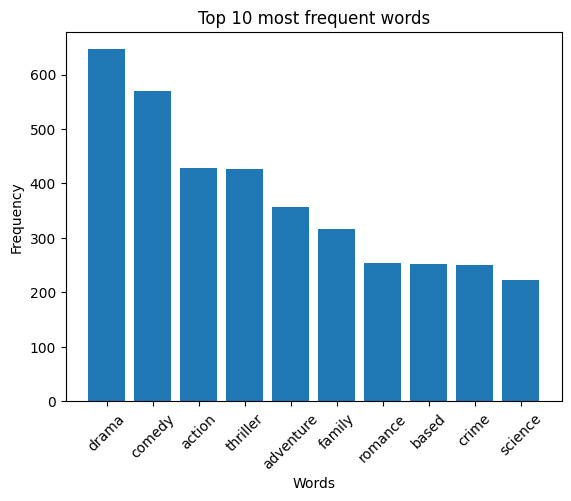

In [426]:
plt.bar(words[:10], freqs[:10])
plt.xlabel('Words')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.title('Top 10 most frequent words')
plt.show()

### Wordcloud is a data visualization technique that displays the most frequent words in a given text as larger and more prominent words. It helps to quickly identify the most important themes or topics in the text. 

    Using word cloud, we can easily visualize the most frequent and prominent words in a given text based on their frequency.

In [569]:
word_freqs = {}
for x in list(pd.DataFrame([words, freqs]).transpose().apply(lambda row: {row[0]: row[1]}, axis=1)):
    for key, val in x.items():
        word_freqs[key] = val

(-0.5, 999.5, 399.5, -0.5)

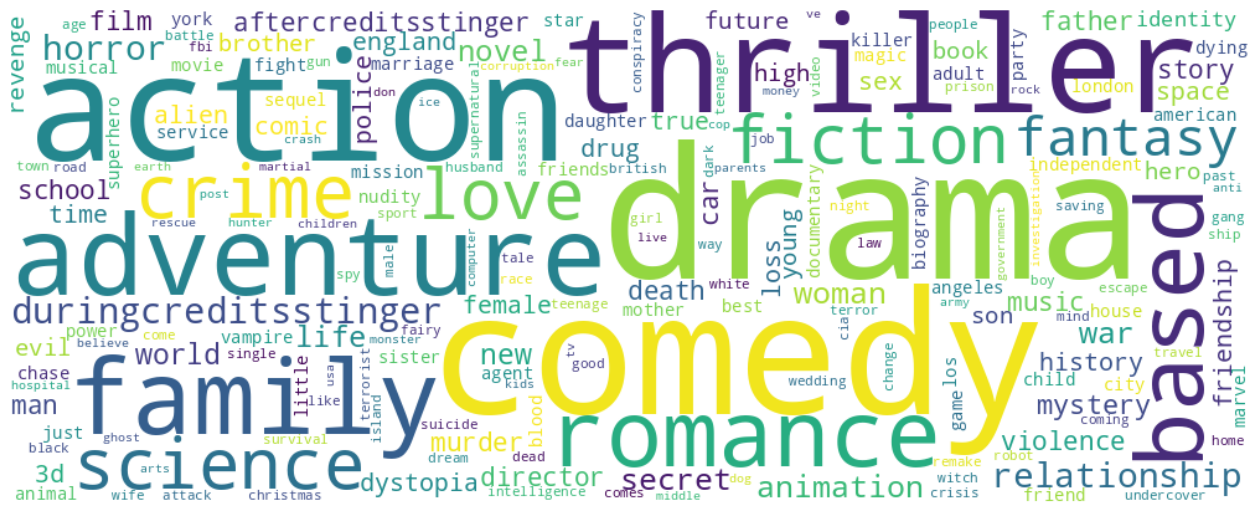

In [570]:
word_cloud = WordCloud(width=1000, height=400, background_color='white')
word_cloud.generate_from_frequencies(word_freqs)
plt.figure(figsize=(16, 8))
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis('off')

### I'll now use consine similarity to find the similarity. Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. It is often used in natural language processing and information retrieval to measure how similar two documents are based on their content. The value of cosine similarity ranges from -1 to 1, with 1 indicating that the two vectors are identical and 0 indicating that they are completely dissimilar. Higher values of cosine similarity indicate greater similarity between the vectors.

The formula for cosine similarity between two vectors A and B can be expressed as:

    cosine_similarity = (A . B) / (||A|| ||B||)

where A . B represents the dot product of A and B, and ||A|| and ||B|| represent the magnitudes of A and B, respectively.
    

In [427]:
cos_results = cosine_similarity(vectorized.toarray())
pd.DataFrame(cos_results)

,0,1,2,3,4,5,6,7,8,9,...,1483,1484,1485,1486,1487,1488,1489,1490,1491,1492
0,1.000000,0.000000,0.026398,0.054133,0.033150,0.081992,0.000000,0.057977,0.069007,0.000000,...,0.000000,0.000000,0.207020,0.050965,0.0,0.000000,0.031388,0.040996,0.000000,0.000000
1,0.000000,1.000000,0.049386,0.025318,0.031009,0.000000,0.262202,0.081349,0.032275,0.000000,...,0.000000,0.000000,0.000000,0.047673,0.0,0.040825,0.000000,0.000000,0.000000,0.064550
2,0.026398,0.049386,1.000000,0.000000,0.030628,0.037878,0.047088,0.107134,0.000000,0.034922,...,0.045083,0.069843,0.063758,0.000000,0.0,0.040324,0.029001,0.000000,0.033296,0.127515
3,0.054133,0.025318,0.000000,1.000000,0.031404,0.000000,0.024140,0.000000,0.490290,0.000000,...,0.000000,0.000000,0.065372,0.144841,0.0,0.000000,0.029735,0.038837,0.000000,0.000000
4,0.033150,0.031009,0.030628,0.031404,1.000000,0.000000,0.029566,0.000000,0.040032,0.000000,...,0.000000,0.000000,0.080064,0.059131,0.0,0.000000,0.182089,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1488,0.000000,0.040825,0.040324,0.000000,0.000000,0.000000,0.155700,0.000000,0.000000,0.000000,...,0.074536,0.115470,0.105409,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.210819
1489,0.031388,0.000000,0.029001,0.029735,0.182089,0.045038,0.000000,0.031846,0.037905,0.041523,...,0.053606,0.000000,0.075810,0.000000,0.0,0.000000,1.000000,0.000000,0.039590,0.075810
1490,0.040996,0.000000,0.000000,0.038837,0.000000,0.000000,0.000000,0.000000,0.049507,0.000000,...,0.000000,0.000000,0.000000,0.073127,0.0,0.000000,0.000000,1.000000,0.000000,0.000000
1491,0.000000,0.000000,0.033296,0.000000,0.000000,0.051709,0.000000,0.036564,0.000000,0.047673,...,0.061546,0.000000,0.000000,0.000000,0.0,0.000000,0.039590,0.000000,1.000000,0.087039


### Now that we have the cosine similarity table for each movie, we can retrieve the movie ID that the user just watched and find its similarity with other movies.

In [428]:
[x for x in keywords_taglines_genres["original_title"] if 'iron' in x.lower()]

['Iron Man', 'Iron Man 2', 'The Iron Giant', 'Iron Man 3', 'The Iron Lady']

In [589]:
movie_title = "Iron Man"
movie_index = [index for index, x in enumerate(keywords_taglines_genres["original_title"] == movie_title) if x == True][0]

In [590]:
movie_index

218

### Once we obtain the movie index, we can utilize the cosine_similarity matrix to determine the 100 most similar movies to the movie ID that the user watched.

In [591]:
top_100_movies = sorted(list(enumerate(cos_results[movie_index])), key=lambda x: x[1], reverse=True)[:100]

In [592]:
top_100_movies[:10]

[(218, 1.0),
 (465, 0.6761234037828133),
 (1207, 0.6696620080077292),
 (1074, 0.6335564128181456),
 (1201, 0.5963765795456271),
 (732, 0.5863527298559492),
 (1199, 0.5749889084999458),
 (1394, 0.5649883385169099),
 (1118, 0.5303948353054367),
 (221, 0.4955585044094361)]

In [594]:
top_movies = pd.DataFrame(np.squeeze(keywords_taglines_genres.values[[np.array(top_100_movies)[:, 0].astype(int)]]), columns=keywords_taglines_genres.columns)
top_movies.head(101)

,id,original_title,genres_combined,keywords_combined,tagline_processed,keywords_taglines_genres
0,1726,Iron Man,action science fiction adventure,middle east arms dealer malibu marvel comic su...,heroes aren't born. they're built.,action science fiction adventure middle east a...
1,10138,Iron Man 2,adventure action science fiction,malibu marvel comic superhero based on comic b...,"it's not the armor that makes the hero, but th...",adventure action science fiction malibu marvel...
2,102899,Ant-Man,science fiction action adventure,marvel comic superhero based on comic book aft...,heroes don't get any bigger.,science fiction action adventure marvel comic ...
3,68721,Iron Man 3,action adventure science fiction,terrorist war on terror tennessee malibu marve...,unleash the power behind the armor.,action adventure science fiction terrorist war...
4,100402,Captain America: The Winter Soldier,action adventure science fiction,washington d.c. future shield marvel comic sup...,in heroes we trust.,action adventure science fiction washington d....
...,...,...,...,...,...,...
95,285,Pirates of the Caribbean: At World's End,adventure fantasy action,ocean drug abuse exotic island east india trad...,"at the end of the world, the adventure begins.",adventure fantasy action ocean drug abuse exot...
96,1487,Hellboy,fantasy action science fiction,black magic fistfight cover-up superhero paran...,from the dark side to our side.,fantasy action science fiction black magic fis...
97,6479,I Am Legend,drama horror action thriller science fiction,saving the world lost civilisation post-apocal...,the last man on earth is not alone,drama horror action thriller science fiction s...
98,68726,Pacific Rim,action science fiction adventure,dystopia giant robot giant monster apocalypse ...,"to fight monsters, we created monsters",action science fiction adventure dystopia gian...


### Okay, cool! So we now have the top 100 recommended movie that similar to the one that watched by the user. We can ignore the first actually, because it's the movie that the user wathced itself.

# 2. Next, we will select the top 50 movies from the 100 movies based on their vote counts. 

To achieve this, we will use the vote average approach, where the Weighted Rating (WR) is calculated using the formula: 
    
     Weighted Rating (WR) = (v / (v + m)) * R + (m / (v + m)) * C

We will now create a new dataframe for this purpose.

In [595]:
second_filters = top_movies.merge(datasets, on="id", how="inner")

In [596]:
second_filters.head(2)

,id,original_title_x,genres_combined,keywords_combined,tagline_processed,keywords_taglines_genres,original_title_y,overview,genres,keywords,tagline,vote_average,vote_count
0,1726,Iron Man,action science fiction adventure,middle east arms dealer malibu marvel comic su...,heroes aren't born. they're built.,action science fiction adventure middle east a...,Iron Man,"After being held captive in an Afghan cave, bi...","[{""id"": 28, ""name"": ""Action""}, {""id"": 878, ""na...","[{""id"": 539, ""name"": ""middle east""}, {""id"": 61...",Heroes aren't born. They're built.,7.4,8776
1,10138,Iron Man 2,adventure action science fiction,malibu marvel comic superhero based on comic b...,"it's not the armor that makes the hero, but th...",adventure action science fiction malibu marvel...,Iron Man 2,With the world now aware of his dual life as t...,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 28, ""...","[{""id"": 8613, ""name"": ""malibu""}, {""id"": 8828, ...","It's not the armor that makes the hero, but th...",6.6,6849


In [597]:
weight_averaged_method = second_filters[["id", "original_title_x", "vote_average", "vote_count"]]

In [598]:
datasets.head(2)

,id,original_title,overview,genres,keywords,tagline,vote_average,vote_count
0,19995,Avatar,"In the 22nd century, a paraplegic Marine is di...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",Enter the World of Pandora.,7.2,11800
1,285,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","At the end of the world, the adventure begins.",6.9,4500


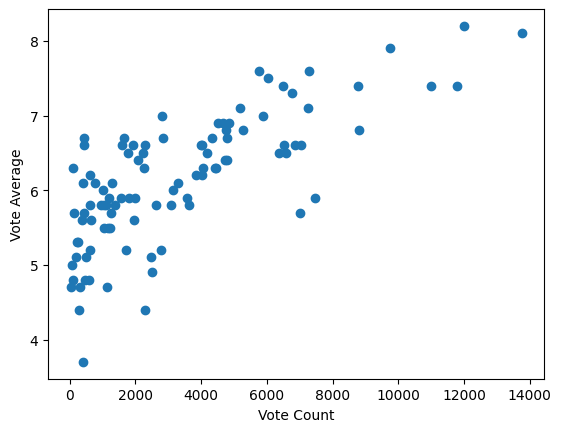

In [599]:
plt.figure()
plt.scatter(weight_averaged_method.vote_count, weight_averaged_method.vote_average)
plt.xlabel('Vote Count')
plt.ylabel('Vote Average')
plt.show()

### Average rating of the movie

In [600]:
weight_averaged_method['R'] = weight_averaged_method.vote_average
weight_averaged_method.R

/tmp/ipykernel_279117/1352299620.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weight_averaged_method['R'] = weight_averaged_method.vote_average


0     7.4
1     6.6
2     7.0
3     6.8
4     7.6
     ... 
95    6.9
96    6.5
97    6.9
98    6.7
99    5.8
Name: R, Length: 100, dtype: float64

### Mean vote (or rating) across all movies.

In [601]:
C = weight_averaged_method.R.mean()
C

6.144999999999999

### Number of votes (or ratings) received by the movie.

In [602]:
weight_averaged_method['v'] = weight_averaged_method.vote_count
weight_averaged_method.v

/tmp/ipykernel_279117/2903200207.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weight_averaged_method['v'] = weight_averaged_method.vote_count


0     8776
1     6849
2     5880
3     8806
4     5764
      ... 
95    4500
96    2225
97    4853
98    4794
99    3095
Name: v, Length: 100, dtype: int64

### Minimum votes (or ratings) required for the movie to be considered.

In [603]:
PERCENTAGE = .95 # set to 95%
m = weight_averaged_method.v.quantile(PERCENTAGE)
print(f"{PERCENTAGE * 100}%", m)

95.0% 8852.799999999997


### Calculate the weighted average ratings using the provided formula.

In [604]:
weight_averaged_method.head(2)

,id,original_title_x,vote_average,vote_count,R,v
0,1726,Iron Man,7.4,8776,7.4,8776
1,10138,Iron Man 2,6.6,6849,6.6,6849


In [605]:
def WR(query):
    R = query.R
    v = query.v
    return (v / (v + m)) * R + (m / (v + m)) * C

In [606]:
weight_averaged_method["WR"] = weight_averaged_method.apply(WR, axis=1)

/tmp/ipykernel_279117/153999692.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weight_averaged_method["WR"] = weight_averaged_method.apply(WR, axis=1)


In [607]:
weight_averaged_method.head(2)

,id,original_title_x,vote_average,vote_count,R,v,WR
0,1726,Iron Man,7.4,8776,7.4,8776,6.769766
1,10138,Iron Man 2,6.6,6849,6.6,6849,6.343467


### We can sort the values and pick the highest scores to select the top 50 movies for recommendation.


In [651]:
weight_averaged_method = weight_averaged_method.sort_values("WR", ascending=False)
weight_averaged_method.reset_index(drop=True, inplace=True)

In [652]:
top_50_movies = weight_averaged_method.head(50)
top_50_movies

,id,original_title_x,vote_average,vote_count,R,v,WR
0,27205,Inception,8.1,13752,8.1,13752,7.334356
1,155,The Dark Knight,8.2,12002,8.2,12002,7.327659
2,118340,Guardians of the Galaxy,7.9,9742,7.9,9742,7.064462
3,24428,The Avengers,7.4,11776,7.4,11776,6.861420
4,293660,Deadpool,7.4,10995,7.4,10995,6.840227
5,286217,The Martian,7.6,7268,7.6,7268,6.800981
6,1726,Iron Man,7.4,8776,7.4,8776,6.769766
7,100402,Captain America: The Winter Soldier,7.6,5764,7.6,5764,6.718766
8,127585,X-Men: Days of Future Past,7.5,6032,7.5,6032,6.694108
9,101299,The Hunger Games: Catching Fire,7.4,6495,7.4,6495,6.676101


# 3. Great! Our next step is to filter the movies based on their content similarity, and for this, we'll be using the movie overview.

In [653]:
contentbased = top_50_movies.merge(datasets[["id", "overview"]], on="id", how="inner")[["id", "original_title_x", "overview"]]
contentbased.columns = ["id", "original_title", "overview"]
contentbased.head(2)

,id,original_title,overview
0,27205,Inception,"Cobb, a skilled thief who commits corporate es..."
1,155,The Dark Knight,Batman raises the stakes in his war on crime. ...


### To ensure that the user's watched movie is among the top 50, we will manually add it if it is not already there, as we need its overview for comparison.

 It appears that the movie is already included, as indicated by the "true" output.

In [654]:
check_movie_exist = True in list(contentbased.original_title == movie_title) 
check_movie_exist

True

If the movie is not present in the list, we can add it manually.

In [655]:
add_title = datasets[["id", "original_title", "overview"]][datasets[["id", "original_title", "overview"]].original_title == movie_title]
add_title

,id,original_title,overview
68,1726,Iron Man,"After being held captive in an Afghan cave, bi..."


In [658]:
contentbased.head(2)

,id,original_title,overview
0,27205,Inception,"Cobb, a skilled thief who commits corporate es..."
1,155,The Dark Knight,Batman raises the stakes in his war on crime. ...


In [659]:
if not check_movie_exist:
    contentbased = pd.concat([contentbased, add_title])
    contentbased = contentbased.reset_index(drop=True)

### To start with, in this scenario, I need to eliminate any numbers or symbols from the overview sentences and convert them all to lowercase.

In [661]:
def func(row):
    text = row.overview.lower()
    text = ' ' . join(re.findall(r"[a-z]+", text))
    return text

contentbased["overview_cleaned"] = contentbased.apply(func, axis=1)
contentbased.head(2)

,id,original_title,overview,overview_cleaned
0,27205,Inception,"Cobb, a skilled thief who commits corporate es...",cobb a skilled thief who commits corporate esp...
1,155,The Dark Knight,Batman raises the stakes in his war on crime. ...,batman raises the stakes in his war on crime w...


### Let's now proceed with extracting their features.






The main difference between CountVectorizer and TfidfVectorizer is that CountVectorizer only counts the occurrences of each word in the document, while TfidfVectorizer considers the frequency of a word across all documents. TfidfVectorizer is better at identifying the most important words in a document or a corpus.

In [662]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_features = tfidf.fit_transform(contentbased.overview_cleaned)

In [663]:
tfidf_features.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.25864559, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

### The cosine similarity can now be computed between them.

In [664]:
cosine_similarity_tbls = cosine_similarity(tfidf_features)

In [665]:
pd.DataFrame(cosine_similarity_tbls)

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,1.000000,0.000000,0.042937,0.000000,0.013003,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.021466,0.031308,0.000000,0.000000,0.000000,0.022277,0.000000,0.000000
1,0.000000,1.000000,0.000000,0.016823,0.000000,0.000000,0.000000,0.026248,0.016284,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.010017,0.000000,0.000000,0.037522,0.000000,0.013694
2,0.042937,0.000000,1.000000,0.029916,0.000000,0.046978,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.030200,0.000000,0.000000,0.000000,0.024352
3,0.000000,0.016823,0.029916,1.000000,0.000000,0.021770,0.000000,0.067766,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.009743,0.027896,0.024608,0.000000,0.000000,0.043165,0.037786
4,0.013003,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.025815,0.018233,0.000000,...,0.014737,0.000000,0.017607,0.000000,0.000000,0.000000,0.000000,0.018272,0.000000,0.000000
5,0.000000,0.000000,0.046978,0.021770,0.000000,1.000000,0.000000,0.000000,0.000000,0.018235,...,0.032734,0.000000,0.000000,0.021808,0.000000,0.021976,0.000000,0.000000,0.000000,0.017721
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.041955,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066272,0.000000
7,0.000000,0.026248,0.000000,0.067766,0.025815,0.000000,0.000000,1.000000,0.013599,0.012031,...,0.010991,0.021069,0.027913,0.011482,0.000000,0.000000,0.000000,0.000000,0.025433,0.000000
8,0.000000,0.016284,0.000000,0.000000,0.018233,0.000000,0.000000,0.013599,1.000000,0.025491,...,0.057665,0.000000,0.050598,0.000000,0.016385,0.000000,0.000000,0.000000,0.000000,0.024773
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.018235,0.000000,0.012031,0.025491,1.000000,...,0.000000,0.031273,0.000000,0.000000,0.054984,0.000000,0.000000,0.000000,0.000000,0.000000


### Let's now retrieve the movie index that we want to examine from the similarity table. 

    It's worth noting that each row in the table contains the similarities of that particular row to all the available movies in the table.

In [690]:
movie_index = [index for index, x in enumerate(contentbased["original_title"] == movie_title) if x == True][0]
movie_index

6

In [707]:
top_movies = pd.DataFrame(list(sorted(enumerate(cosine_similarity_tbls[movie_index]), key=lambda x: x[1], reverse=True)))
top_movies.columns = ["top_index", "cosine_similarity"]
top_movies.head(15)

,top_index,cosine_similarity
0,6,1.000000
1,22,0.134759
2,10,0.103970
3,14,0.103463
4,48,0.066272
5,41,0.041955
6,13,0.036959
7,28,0.030540
8,25,0.028069
9,37,0.026785


In [718]:
top_15_movies = pd.DataFrame(contentbased[["id", "original_title"]].values[top_movies.top_index[:16]], columns=["id", "original_title"]) 

In [719]:
print(f"The movies related to the {movie_title} movie that the user just watched are ...\n", top_15_movies.values[1:])

The movies related to the Iron Man movie that the user just watched are ...
 [[10138 'Iron Man 2']
 [99861 'Avengers: Age of Ultron']
 [68721 'Iron Man 3']
 [262500 'Insurgent']
 [1893 'Star Wars: Episode I - The Phantom Menace']
 [102899 'Ant-Man']
 [1858 'Transformers']
 [558 'Spider-Man 2']
 [1487 'Hellboy']
 [27205 'Inception']
 [155 'The Dark Knight']
 [118340 'Guardians of the Galaxy']
 [24428 'The Avengers']
 [293660 'Deadpool']
 [286217 'The Martian']]


# <font color='red'>We have obtained the final output of our basic movie recommendation system!</font>

### There are various ways to tackle this problem. In this approach, I am finding the movies sequentially based on the previous results. 

Another solution could be to calculate their similarity separately and then select the movies based on their presence in each recommendation approach that we used.